# Scikit Model Selection
Scikit offers different types of hyperparameter tuning algorithms.
![](images/scikit_model_selection_algorithms.png)
[Image source](https://medium.com/@jackstalfort/hyperparameter-tuning-using-grid-search-and-random-search-f8750a464b35)

## Hyperparameters vs. parameters

A learning model usually has both **parameters** and **hyperparameters**. What's the difference between the two?

Take for instance a Polynomial Regression model: $y = w_0 + w_1x + w_2x^2 + \dots + w_mx^m$

It has both parameters ($w_i$) and one hyperparameter (m). Now comes the main differences between parameters and hyperparameters. Parameters are chosen (actually learned) by the algorithm and hyperparameters are chosen by machine learning expert (i.e. you). The weights $w_i$ are used to weigh the input $x$ and $m$ determines the degree of the polynomial. The higher the degree the more expressive power that is harnessed in the model, but also the higher the risk of overfitting becomes. So tuning this hyperparameter $m$ is crucial in obtaining optimal results, and optimal means picking that value that lets the model generalize well over unseen examples.

In the above example there is only one hyperparameter ($m$). The figures above depict situations with two hyperparameters, but in general there can be many more.

## Setup the model

Now we create a Scikit pipeline that will be used to train the model. The pipeline consists of a PolynomialFeatures transformer and a LinearRegression estimator. The PolynomialFeatures transformer will create polynomial features from the input data. The LinearRegression estimator will train a linear regression model on the data. The pipeline will be used to train the model with different hyperparameters.

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

model = Pipeline([('poly', PolynomialFeatures()),
                  ('linear', LinearRegression())])
model

Pipeline(steps=[('poly', PolynomialFeatures()), ('linear', LinearRegression())])

In [3]:
import pandas as pd
from IPython.core.display_functions import display

display(pd.DataFrame(model['poly'].get_params(), index=['poly']))
display(pd.DataFrame(model['linear'].get_params(), index=['linear']))
pd.set_option('display.max_rows', None)
pd.DataFrame([model.get_params().keys(), model.get_params().values()], index=['key', 'value']).T

,degree,include_bias,interaction_only,order
poly,2,True,False,C


,copy_X,fit_intercept,n_jobs,normalize,positive
linear,True,True,None,deprecated,False


,key,value
0,memory,None
1,steps,"[(poly, PolynomialFeatures()), (linear, Linear..."
2,verbose,False
3,poly,PolynomialFeatures()
4,linear,LinearRegression()
5,poly__degree,2
6,poly__include_bias,True
7,poly__interaction_only,False
8,poly__order,C
9,linear__copy_X,True


The first two tables show the parameters of the PolynomialFeatures transformer and the LinearRegression estimator. The last table shows the hyperparameters of the entire pipeline. The hyperparameters of the pipeline are the hyperparameters of the transformers and estimators that are part of the pipeline. The hyperparameters of the pipeline can be accessed by using the get_params() method.

We see that our model actually has 14 different hyperparameters. The hyperparameters of the PolynomialFeatures transformer are prefixed with `poly__` and the hyperparameters of the LinearRegression estimator are prefixed with `linear__`. Some of the hyperparameters are deprecated and will be removed in future versions of Scikit. See documentation for more information.

What's important to us is to know the names of the parameters in the pipeline. We will use these names to specify the hyperparameters that we want to tune. We're only going to tune `poly__degree` and `linear__fit_intercept`. The other hyperparameters will be left at their default values. `poly__degree` determines the degree of the polynomial (default value is 2) and `linear__fit_intercept` determines whether or not to fit an intercept term in the model (default value is `True`)

## Load the data
We will use the same data from an earlier course. The data is about the relationship between the wage you earn and the number of LinkedIn connections you have. The data is available in the file `datasets/linkedin.csv`. The data is loaded into a Pandas DataFrame, and we make a scatter plot of the data.

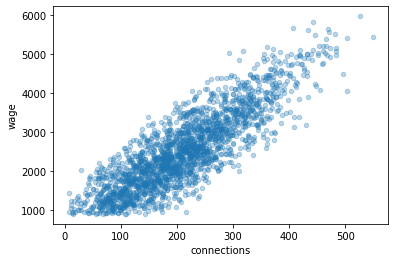

In [4]:
import pandas as pd

linkedin = pd.read_csv('datasets/linkedin.csv')
_ = linkedin.plot(kind='scatter', x='connections', y='wage', alpha=0.3)

# Grid Search
As explained above, Grid search is a way to find the best parameters for a model. It uses a grid of parameters to find the best model. Think of a grid as a matrix of parameters.
By trying each parameter combination, we can find the best model within the bounds of the grid, of course.

In [5]:
from sklearn.model_selection import GridSearchCV

# define the hyperparameters dictionary
hyperparameters = {'poly__degree': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                   'linear__fit_intercept': [True, False],
                   'poly__include_bias': [True, False]}

X = linkedin[['connections']]
y = linkedin['wage']

gridsearch = GridSearchCV(model, hyperparameters, cv=5)
best_model = gridsearch.fit(X, y)
best_model.best_estimator_

Pipeline(steps=[('poly', PolynomialFeatures(degree=3, include_bias=False)),
                ('linear', LinearRegression())])

### Custom scorer
We can also use a custom scorer to find the best model. The custom scorer is a function that takes two arguments: `y_true` and `y_pred`. The function should return a single value that is used to compare the models. The model with the *best* score is the best model. But best is relative to the problem at hand. Sometimes a higher score is better, sometimes a lower score is better. The custom scorer function should take this into account using the parameter `greater_is_better`. If `greater_is_better` is `True` then the model with the highest score is the best model. If `greater_is_better` is `False` then the model with the lowest score is the best model.


In [6]:
from sklearn.metrics import make_scorer, mean_squared_error, r2_score


# custom scorer function, which is actually the default scorer
def r_squared(y_true, y_pred):
    r_square = 1 - mean_squared_error(y_true, y_pred) / y_true.var()
    return r_square


r_squared_scorer = make_scorer(r_squared, greater_is_better=True)
gridsearch = GridSearchCV(model, hyperparameters, scoring=r_squared_scorer, cv=5, verbose=1)
gridsearch.fit(X, y)
display(gridsearch.best_estimator_)
r2_score(y, gridsearch.best_estimator_.predict(X))

Fitting 5 folds for each of 40 candidates, totalling 200 fits


Pipeline(steps=[('poly', PolynomialFeatures(degree=3, include_bias=False)),
                ('linear', LinearRegression())])

0.7370060774832599

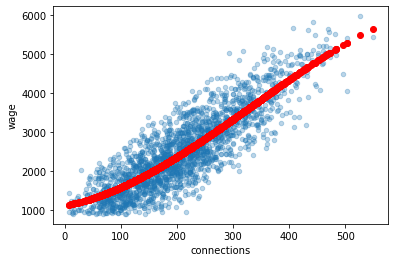

In [16]:
ax = linkedin.plot(kind='scatter', x='connections', y='wage', alpha=0.3)
_ = ax.scatter(X, gridsearch.best_estimator_.predict(X), color='red')

# Random Search


In [7]:
from sklearn.model_selection import RandomizedSearchCV

randomsearch = RandomizedSearchCV(model, hyperparameters, cv=5, n_iter=5, verbose=1)
randomsearch.fit(X, y)
display(randomsearch.best_estimator_)
r2_score(y, randomsearch.best_estimator_.predict(X))


Fitting 5 folds for each of 5 candidates, totalling 25 fits


Pipeline(steps=[('poly', PolynomialFeatures(degree=6)),
                ('linear', LinearRegression())])

0.7371037271966195

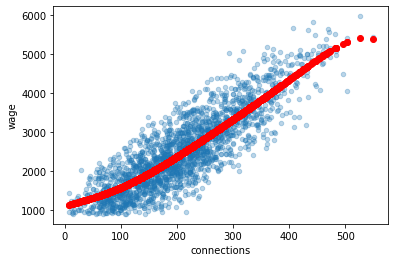

In [17]:
ax = linkedin.plot(kind='scatter', x='connections', y='wage', alpha=0.3)
_ = ax.scatter(X, randomsearch.best_estimator_.predict(X), color='red')

## Bayesian Optimization


In [11]:
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer

# define the hyperparameters dictionary
hyperparameters = {
    'poly__degree': Integer(1, 10),
    'linear__fit_intercept': Categorical([True, False]),
    'poly__include_bias': Categorical([True, False])}

bayessearch = BayesSearchCV(model, hyperparameters, cv=5, n_iter=5)
bayessearch.fit(X, y)
bayessearch.best_estimator_


Pipeline(steps=[('poly', PolynomialFeatures(degree=3, include_bias=False)),
                ('linear', LinearRegression())])

In [12]:
r2_score(y, bayessearch.best_estimator_.predict(X))

0.7370060774832599

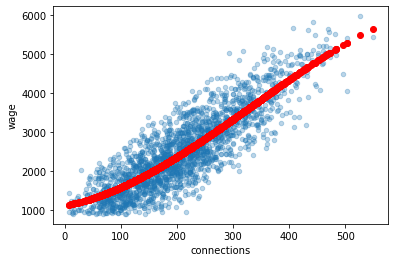

In [18]:
ax = linkedin.plot(kind='scatter', x='connections', y='wage', alpha=0.3)
_ = ax.scatter(X, bayessearch.best_estimator_.predict(X), color='red')
